# MNIST DCGAN Example

**Note**: This notebook is desinged to run on GPU runtime.

**[MDE-01]**

Install libraries.

In [1]:
%%bash
curl -sLO https://raw.githubusercontent.com/enakai00/colab_jaxbook/main/requirements.txt
pip install -qr requirements.txt
pip list | grep -E '(jax|flax|optax)'

flax                          0.6.1
jax                           0.3.21
jaxlib                        0.3.15+cuda11.cudnn805
optax                         0.1.3


**[MDE-02]**

Import modules.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from functools import partial
from tensorflow.keras.datasets import mnist

import jax, optax
from jax import random, numpy as jnp
from flax import linen as nn
from flax.training import train_state

plt.rcParams.update({'font.size': 12})

**[MDE-03]**

Download the MNIST dataset and store into NumPy arrays.

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape([-1, 784]).astype('float32') / 255
test_images = test_images.reshape([-1, 784]).astype('float32') / 255
train_labels = np.eye(10)[train_labels]
test_labels = np.eye(10)[test_labels]

**[MDE-04]**

Define a function to split the dataset into batches.

In [4]:
def create_batches(data, batch_size):
    num_batches, mod = divmod(len(data), batch_size)
    data_batched = np.array_split(data[:num_batches * batch_size], num_batches)
    if mod: # Last batch is smaller than batch_size
        data_batched.append(data[num_batches * batch_size:])
    data_batched = [jnp.asarray(x) for x in data_batched]
    return data_batched

**[MDE-05]**

Define a generator model.

In [5]:
class Generator(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=7*7*128)(x)
        x = nn.leaky_relu(x, 0.3)
        x = x.reshape([-1, 7, 7, 128])
        x = nn.ConvTranspose(features=64, kernel_size=(5, 5), strides=(2, 2))(x)
        x = nn.leaky_relu(x, 0.3)
        x = nn.ConvTranspose(features=1, kernel_size=(5, 5), strides=(2, 2))(x)
        x = nn.sigmoid(x)
        x = x.reshape([x.shape[0], -1])  # flatten
        return x

**[MDE-06]**

Define a discriminator model.

In [6]:
class Discriminator(nn.Module):
    @nn.compact
    def __call__(self, x, get_logits=False, eval=True):
        x = x.reshape([-1, 28, 28, 1])
        x = nn.Conv(features=64, kernel_size=(5, 5), strides=(2, 2))(x)
        x = nn.leaky_relu(x, 0.3)
        x = nn.Conv(features=128, kernel_size=(5, 5), strides=(2, 2))(x)
        x = nn.leaky_relu(x, 0.3)
        x = x.reshape([x.shape[0], -1])  # flatten
        x = nn.Dropout(0.4, deterministic=eval)(x)
        x = nn.Dense(features=1)(x)
        if get_logits:
            return x
        x = nn.sigmoid(x)
        return x

**[MDE-07]**

Create a training state object.

In [7]:
class TrainState(train_state.TrainState):
    sampling_rng: type(random.PRNGKey(0))


latent_dim = 64
key, key1, key2, key3, key4 = random.split(random.PRNGKey(0), 5)

variables_gen = Generator().init(key1, jnp.zeros([1, latent_dim]))
state_gen = TrainState.create(
    apply_fn=Generator().apply,
    params=variables_gen['params'],
    tx=optax.adam(learning_rate=0.001, b1=0.4, b2=0.8),
    sampling_rng=key2)

variables_disc = Discriminator().init(
    key3, train_images[0:1], {'dropout': random.PRNGKey(0)})
state_disc = TrainState.create(
    apply_fn=Discriminator().apply,
    params=variables_disc['params'],
    tx=optax.adam(learning_rate=0.001, b1=0.4, b2=0.8),
    sampling_rng=key4)

**[MDE-08]**

Define a loss funcion to train the generator.

In [8]:
@jax.jit
def loss_gen(params_gen, params_disc, inputs, labels):
    images = Generator().apply({'params': params_gen}, inputs)
    logits = Discriminator().apply(
        {'params': params_disc}, images, get_logits=True, eval=True)
    loss = optax.sigmoid_binary_cross_entropy(logits, labels).mean()
    return loss

**[MDE-09]**

Define a loss funcion to train the discriminator.

In [9]:
@jax.jit
def loss_disc(params_disc, inputs, labels, dropout_rng):
    logits = Discriminator().apply(
        {'params': params_disc}, inputs, get_logits=True, eval=False,
        rngs={'dropout': dropout_rng})
    loss = optax.sigmoid_binary_cross_entropy(logits, labels).mean()
    return loss

**[MDE-10]**

Define a function to apply a single training step to the generator.

In [10]:
@partial(jax.jit, static_argnames=['batch_size'])
def train_step_gen(state_gen, state_disc, batch_size):
    global latent_dim

    new_sampling_rng, key1 = random.split(state_gen.sampling_rng)
    random_inputs = random.uniform(
        key1, (batch_size, latent_dim), minval=-1, maxval=1)
    fake_labels = jnp.ones([batch_size, 1])

    loss, grads = jax.value_and_grad(loss_gen)(
        state_gen.params, state_disc.params, random_inputs, fake_labels)
    new_state_gen = state_gen.apply_gradients(
        grads=grads, sampling_rng=new_sampling_rng)
  
    return new_state_gen, loss

**[MDE-11]**

Define a function to apply a single training step to the discriminator.

In [11]:
@partial(jax.jit, static_argnames=['batch_size'])
def train_step_disc(state_disc, state_gen, real_images, batch_size):
    global latent_dim

    new_sampling_rng, key1, key2 = random.split(state_disc.sampling_rng, 3) 
    random_inputs = random.uniform(
        key1, (batch_size, latent_dim), minval=-1, maxval=1)
    generated_images = Generator().apply(
        {'params': state_gen.params}, random_inputs)
    all_images = jnp.concatenate([generated_images, real_images])
    labels = jnp.concatenate([jnp.zeros([batch_size, 1]),
                              jnp.ones([batch_size, 1])])
  
    loss, grads = jax.value_and_grad(loss_disc)(
        state_disc.params, all_images, labels, dropout_rng=key2)
    new_state_disc = state_disc.apply_gradients(
        grads=grads, sampling_rng=new_sampling_rng)
  
    return new_state_disc, loss

**[MDE-12]**

Define a function to apply a single training step to the discriminator and generator.

In [12]:
@jax.jit
def train_step(state_gen, state_disc, train_images_batch):
    batch_size = len(train_images_batch)

    # Train discriminator
    real_images = train_images_batch
    state_disc, loss_disc = train_step_disc(
        state_disc, state_gen, real_images, batch_size)

    # Train generator
    state_gen, loss_gen = train_step_gen(state_gen, state_disc, batch_size)

    return state_gen, state_disc, loss_gen, loss_disc

**[MDE-13]**

Define a function to apply the training steps for one epoch.

In [13]:
def train_epoch(state_gen, state_disc, input_batched):
    loss_gen_history, loss_disc_history = [], []

    for inputs in input_batched:
        state_gen, state_disc, loss_gen, loss_disc = train_step(
            state_gen, state_disc, inputs)
        loss_gen_history.append(jax.device_get(loss_gen).tolist())
        loss_disc_history.append(jax.device_get(loss_disc).tolist())

    loss_gen, loss_disc = np.mean(loss_gen_history), np.mean(loss_disc_history)

    return state_gen, state_disc, loss_gen, loss_disc

**[MDE-14]**

Repeat the training steps for multiple epochs and store sample images.

In [14]:
%%time
examples = []
sample_inputs = 0.7 * random.uniform(key, (8, latent_dim), minval=-1, maxval=1)
examples.append(jax.device_get(
    Generator().apply({'params': state_gen.params}, sample_inputs)))

batch_size = 32
train_images_batched = create_batches(train_images, batch_size)

for epoch in range(1, 17):
    state_gen, state_disc, loss_gen, loss_disc = train_epoch(
        state_gen, state_disc, train_images_batched)
    print('Epoch: {}, Loss(discriminator, generator): {:.4f}, {:.4f}'.format(
        epoch, loss_disc, loss_gen), flush=True)
    examples.append(jax.device_get(
        Generator().apply({'params': state_gen.params}, sample_inputs)))

Epoch: 1, Loss(discriminator, generator): 0.3758, 7.5184
Epoch: 2, Loss(discriminator, generator): 0.5760, 1.4328
Epoch: 3, Loss(discriminator, generator): 0.6037, 1.2108
Epoch: 4, Loss(discriminator, generator): 0.5893, 1.2653
Epoch: 5, Loss(discriminator, generator): 0.5786, 1.3131
Epoch: 6, Loss(discriminator, generator): 0.5721, 1.3533
Epoch: 7, Loss(discriminator, generator): 0.5659, 1.3828
Epoch: 8, Loss(discriminator, generator): 0.5605, 1.4170
Epoch: 9, Loss(discriminator, generator): 0.5539, 1.4343
Epoch: 10, Loss(discriminator, generator): 0.5548, 1.4315
Epoch: 11, Loss(discriminator, generator): 0.5542, 1.4455
Epoch: 12, Loss(discriminator, generator): 0.5570, 1.4326
Epoch: 13, Loss(discriminator, generator): 0.5519, 1.4492
Epoch: 14, Loss(discriminator, generator): 0.5540, 1.4409
Epoch: 15, Loss(discriminator, generator): 0.5555, 1.4306
Epoch: 16, Loss(discriminator, generator): 0.5556, 1.4201
CPU times: user 4min 13s, sys: 10.2 s, total: 4min 23s
Wall time: 4min 38s


**[MDE-15]**

Show sample images generated at each epoch.

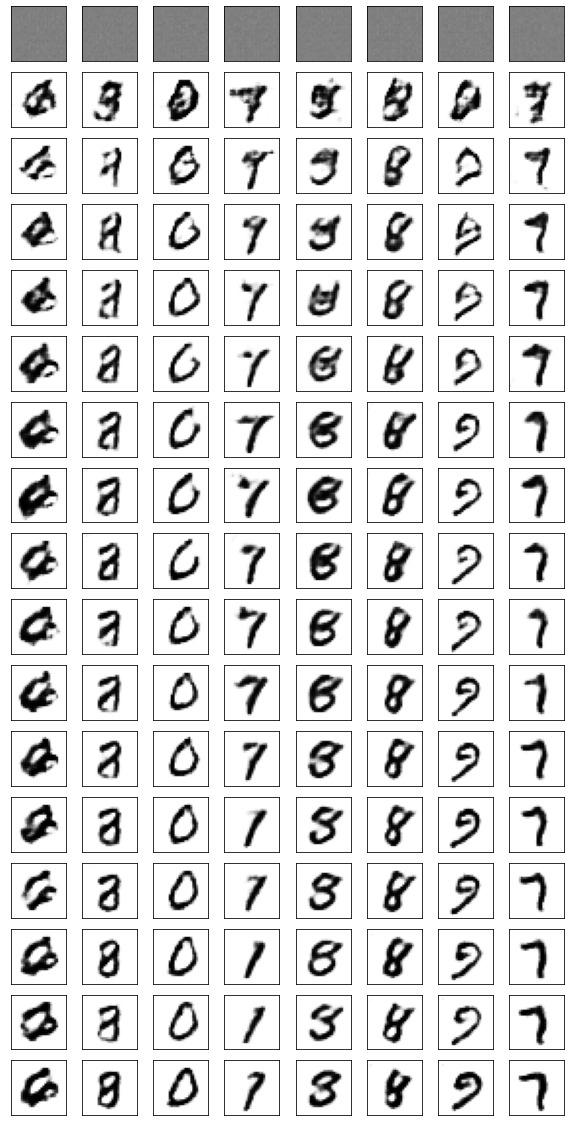

In [15]:
def show_examples(examples):
    fig = plt.figure(figsize=(10, 1.2*len(examples)))
    c = 1
    for images in examples:
        for image in images:
            subplot = fig.add_subplot(len(examples), 8, c)
            subplot.set_xticks([])
            subplot.set_yticks([])
            subplot.imshow(image.reshape([28, 28]),
                           vmin=0, vmax=1, cmap=plt.cm.gray_r)
            c += 1

show_examples(examples)

**[MDE-16]**

Show sample images using the trained generator.

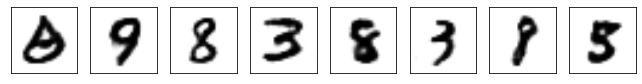

In [88]:
def show_images(images):
    fig = plt.figure(figsize=(len(images)*1.4, 1.4))
    for c, image in enumerate(images):
        subplot = fig.add_subplot(1, len(images), c+1)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(image.reshape([28, 28]), vmin=0, vmax=1,
                       cmap=plt.cm.gray_r, interpolation='bilinear')
    
random_inputs = 0.7 * (np.random.rand(8, latent_dim) * 2.0 - 1.0)
images = Generator().apply({'params': state_gen.params}, random_inputs)
show_images(images)

**[MDE-17]**

Show image transition following a linear change of the latent variable.

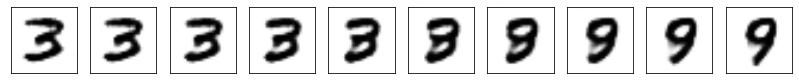

In [92]:
start, end = random_inputs[3], random_inputs[1]

interpolation = [np.linspace(s, e, 10) for s, e in zip(start, end)]
example = np.array([[x[c] for x in interpolation] for c in range(10)])
show_images(Generator().apply({'params': state_gen.params}, example))

**[MDE-18]**

Generate a demo animation of the dancing digit.

In [95]:
import matplotlib.animation as animation

x = 0.7 * np.random.rand(3, latent_dim) * 2.0 - 1.0
inputs = []
theta1, theta2 = 0, 0
for _ in range(64):
    theta1 += 2*np.pi / 64 * 2
    theta2 += 2*np.pi / 64
    inputs.append(np.cos(theta1) * x[0] + \
        np.sin(theta1)*(np.cos(theta2)*x[1] + np.sin(theta2)*x[2]))
res = Generator().apply({'params': state_gen.params}, inputs)

images = []
fig = plt.figure(figsize=(2, 2))
for i in range(len(res)):
    subplot = fig.add_subplot(1, 1, 1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    image = subplot.imshow(res[i].reshape([28, 28]), vmin=0, vmax=1,
                           cmap=plt.cm.gray_r, interpolation='bilinear')
    images.append([image])
ani = animation.ArtistAnimation(fig, images, interval=10, repeat=True)
ani.save('DCGAN_morphing.gif', writer='pillow')#, fps=55)
plt.clf()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


<Figure size 144x144 with 0 Axes>

**[MDE-19]**

Show the generated animation.

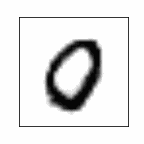

In [96]:
from IPython.display import Image
Image('DCGAN_morphing.gif', format='gif')